In [1]:
import gc
import math
import random

import torch
import torch.nn as nn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange
from pathlib import Path

d:\code\dementiakiller\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONFIG

# Training
LR = 0.0008
BS = 32 # DO NOT CHANGE ATM fixed to numpy folder as each bach is saved as a numpy array 

DEVICE = 'cuda'

CHARSET = " .,!abcdefghijklmnopqrstuvwxyz"


 # TODO: Clean this up
FOLDER = Path('data/LJSpeech-1.1/wavs')

path_numpy = FOLDER.parent / Path('numpy')
path_data = path_numpy / Path('data')
path_labels = path_numpy / Path('labels')
path_input = path_numpy / Path('input_lengths')
path_target = path_numpy / Path('target_lengths')

path_models = Path('models')

path_models.mkdir(exist_ok=True)

In [3]:
# Model (Simple to get started)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.ln1 = nn.Sequential(
                                nn.Linear(50,100),
                                nn.ReLU(),                                
                                nn.Linear(100,250),
                                nn.ReLU(),
                                nn.Linear(250,500),
                                nn.ReLU(),
                                nn.Linear(500,500),
                                nn.ReLU(),
                                )

        self.gru = nn.GRU(500, 500, batch_first=False)
        self.ln2 = nn.Sequential(
                        nn.Linear(500, 250),
                        nn.ReLU(),
                        nn.Linear(250, 75),
                        nn.ReLU(),
                        nn.Linear(75,len(CHARSET)),
                         )

    def forward(self, x):
        x = self.ln1(x)
        x = nn.functional.relu(self.gru(x)[0])
        x = self.ln2(x)
        x = torch.nn.functional.log_softmax(x, dim=2)
        return x

model = Net().to(DEVICE)


In [4]:
# How are shapes with CTC loss working? 
# INPUT [time,batch,mels]
inn = torch.rand(1114,32,50, device=DEVICE)
print(f"Input shape: {inn.shape}")
test = model(inn)

print(f"Output shape: {test.shape}")
# OUTPUT [time,batch,len(CHARSET)]

Input shape: torch.Size([1114, 32, 50])
Output shape: torch.Size([1114, 32, 30])


In [5]:
# Criterion (Loss function) and Optimizer
criterion  = nn.CTCLoss(reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [6]:
# TODO: we need to shuffle, currently every batch and epoch are the same
# TODO: Normalize data?
# TODO: Char mappings how are padding handled vs space 

EPOCHS = 200

traning_loss = []

t = trange(EPOCHS)

for epoch in t:
    for batch in range(408):
        batch = random.randint(0, 408) # BUG: HAX: TODO: BAD
        inputs = np.load(path_data / Path(str(batch) + '.npy'))
        labels = np.load(path_labels / Path(str(batch) + '.npy'))
        input_lengths = np.load(path_input / Path(str(batch) + '.npy'))
        target_lengths = np.load(path_target / Path(str(batch) + '.npy'))

        inputs = torch.tensor(inputs).reshape(-1,BS,50).float().to(DEVICE)
        labels = torch.tensor(labels).float().to(DEVICE)
        input_lengths = torch.tensor(input_lengths)
        target_lengths = torch.tensor(target_lengths)
        
        #inputs = torch.nn.functional.normalize(inputs)

        optimizer.zero_grad() # Reset gradient to zero

        # Forward
        output = model(inputs) 

        # Compute loss
        loss = criterion(output, labels, input_lengths,target_lengths)

        # Update loss
        loss.backward()

        # optimizer
        optimizer.step()
        if batch % 10 == 0:
            t.set_description(f"Loss: {loss.item()}")
            traning_loss.append(loss.item())

        del inputs
        del labels
    
    if True:
        torch.save(model.state_dict(), f"models/{str(epoch)}.pt")
    


Loss: 2.6486241817474365:  40%|████      | 80/200 [52:31<1:18:47, 39.40s/it]


KeyboardInterrupt: 

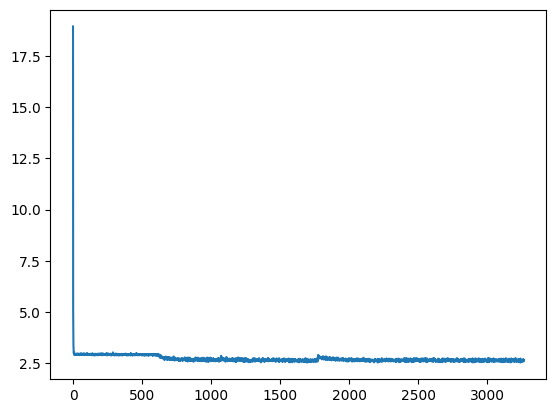

In [7]:
plt.plot(traning_loss)

In [16]:
# TEST
TEST = 23 
TEST2 = 0

data = np.load(path_data / Path(str(TEST) + '.npy'))
data = torch.tensor(data[TEST2]).float()
data = data[:,:,None].permute(1,2,0).to(DEVICE)
print(data.shape)

# Run the model
output = model(data)
output = output[:, 0, :].argmax(dim=1)

estimate = []
for char in output:
    if char != 0:
        estimate.append(CHARSET[char-1])
print(''.join(estimate))

torch.Size([1114, 1, 50])
he e e e e e e 


In [17]:
# VERIFY
labels = np.load(path_labels / Path(str(batch) + '.npy'))

correct = []
for char in labels[0]:
    if char != 0:
        correct.append(CHARSET[char-1])
print(''.join(correct))

in the crowd, all of them persons who had  no other avocation or mode of livelihood but thieving,  mr. buxton counted eleven children
